20171103
Time evolution of matrix product mixed state

In [2]:
import numpy as np
import time
import scipy
from tqdm import tqdm
from scipy import linalg
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import io
import smtplib

In [125]:
sx=np.array([[0.,1.],[1.,0.]])
sy=np.array([[0.,-1j],[1j,0.]])
sz=np.array([[1.,0.],[0.,-1.]])

for epsilon in np.array([0.15]):
    d=2 # Dimension. For spin 1/2 the dimention = 2
    J=1. # XX interaction coefficient
    gz=0. # Z field strength
    gx=0. # X field strength
    delta =0.02 # Time step
    interaction='Dipolar' # Heisenberg: J(XX+YY+ZZ); Ising: JXX; Dipolar J(XX-(YY+ZZ)/2)
    beta=0.001 # inverse temperature
    pol=sx # initial polarization
    chi=800 # Maximum number of singular values
    thr=1e-10; # discarding singular values smaller than thr*largest singular value
    #epsilon=0.03
    #T=3;

    if interaction=='Heisenberg':
        h_int=J*np.kron(sx,sx)+J*np.kron(sy,sy)+J*np.kron(sz,sz)
    elif interaction=='Ising':
        h_int=J*np.kron(sx,sx)
    elif interaction=='Dipolar':
        h_int=J*(np.kron(sx,sx)-np.kron(sz,sz)/2-np.kron(sy,sy)/2)
    else:
        raise NameError('Invalid interaction')
    h_single=gz*sz+gx*sx
    U_int=linalg.expm(-1j*h_int*delta).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')

    Mz=np.kron(sz,np.eye(d))+np.kron(np.eye(d),sz)
    Mz=Mz.reshape(d,d,d,d)
    Mx=np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx)
    Mx=Mx.reshape(d,d,d,d)

    #rho0i=np.transpose(np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]]),(2,3,0,1)) # rho0i(si,si',ai,bi)
    rho0i=linalg.expm(-beta/2*pol).reshape(d,d,1,1)/np.sqrt(np.exp(beta)+np.exp(-beta)) # rho0i(si,si',ai,bi)
    rho0=[rho0i,rho0i]

    band0i=np.ones(1)
    band0=[band0i,band0i]

    def exp1(rho,band,U):
        #1e-6 should be good enough
        E=[]
        for A in range(0,2):
            B=1-A
            theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
            theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(a0,s0,s0',b0)
            theta=np.tensordot(theta,np.conj(theta),axes=([0,2,3],[0,2,3])) # theta(s0,s0*)
            E.append(np.tensordot(theta,U,axes=([0,1],[0,1])))
        return np.mean(E)

    def evo1(rho,U):
        for A in range(0,2):
            theta=np.tensordot(U,rho[A],axes=([1,0])) # theta(s,s',a,b,)
            rho[A]=theta

    def evo2(rho,band,U,chi,direction):
        if direction=='f':
            rangep=range(0,2)
        elif direction=='b':
            rangep=range(1,-1,-1)
        else:
            raise NameError('Invalid direction')
        for A in rangep:
            B=1-A
            #print(A,B)
            dB=(rho[A].shape[2])
            theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
            theta=np.transpose(theta,(1,2,0,3)) # theta(s0,s0',a0,b0)
            theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(s0,s0',a0,b0)
            theta=np.tensordot(theta,rho[B],axes=(3,2)) # theta(s0,s0',a0,s1,s1',b1)
            theta=np.tensordot(theta,np.diag(band[B]),axes=(5,0))# theta(s0,s0',a0,s1,s1',b1)

            # Apply U
            theta=np.tensordot(theta,U,axes=([0,3],[2,3])) # theta(s0',a0,s1',b1,s0,s1)
            theta=np.transpose(theta,(4,0,1,5,2,3)) # theta(s0,s0',a0,s1,s1',b1)
            sh=theta.shape
            theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5]) # theta(s0*s0'*a0,s1*s1'*b1)
            [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
            ent=S.shape[0];
            #print(S)
            for i in range(1,S.shape[0]):
                if S[i]<thr*S[0]:
                    ent=i
                    break
            if ent<chi:
                D=S[0:ent]
            else:
                ent=chi
                D=S[0:ent]
            sq=np.sqrt(sum(D**2))
            band[A]=D/sq
            L=L[:,0:ent]
            R=R[0:ent,:]

            L=L.reshape(d,d,dB,ent) # L(s0,s0',a0,b0)
            L=np.tensordot(L,np.diag(band[B]**-1),axes=(2,0)) # L(s0,s0',b0,a0)
            rho[A]=np.transpose(L,(0,1,3,2))
            R=R.reshape(ent,d,d,dB) # R(a1,s1,s1',b1)
            R=np.tensordot(R,np.diag(band[B]**-1),axes=(3,0)) # R(a1,s1,s1',b1)
            R=np.transpose(R,(1,2,0,3)) # R(s1,s1',a1,b1)
    #         test=np.tensordot(L,np.diag(lda[A]),axes=([3,0])) # test(s0,s0',a0,b0)
    #         test=np.tensordot(test,R,axes=([3,2])) # test(s0,s0',a0,s1,s1',b1)
            rho[B]=R
    #         print('A=',rho[A])
    #         print('B=',rho[B])
    #         print('bandA=',band[A])
    #         print('bandB=',band[B])
    # def evo(rho,band,U_int,U_single,Nsteps,chi):
    #     for p in range(0,Nsteps):
    #         evo2(rho,band,U_local,chi,'f')
    #         evo2(rho,band,U_local,chi,'f')
    def evo(rho,band,U_int,U_single,Nsteps,chi):
        for p in range(0,Nsteps):
            evo2(rho,band,U_int,chi,'f')

    def overlap(rho1,band1,rho2,band2):
        E=[]
        for A in range(0,2):
            B=1-A
            theta=np.tensordot(rho1[A],rho2[A],axes=([0,1],[0,1])) # theta(1a,1b,2a,2b)
            theta=np.tensordot(np.diag(band1[A]),theta,axes=(0,1)) # theta(1b,1a,2a,2b)
            theta=np.tensordot(theta,np.diag(band2[A]),axes=(3,0)) # theta(1b,1a,2a,2b)
            theta=np.transpose(theta,(1,0,2,3)) # theta(1a,1b,2a,2b)
            sh=theta.shape
            theta=theta.reshape(sh[0]*sh[1],sh[2]*sh[3])
            w=np.linalg.eigvals(theta)
            wp=np.real(w)
            Meig=wp.argmax()
            E.append(wp[Meig])
        return np.mean(E)-1/2

    start=time.time()
    V0=sz # pi pulse axis

    T=10 # evolution time to be simulated
    Nsteps=25 # number of evolution steps between two measurements
    Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
    tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

    U_phi=linalg.expm(1j*np.pi*(1+epsilon)/2*V0)
    MExp=np.zeros(Npts)

    rho=list(rho0)
    band=list(band0)
    MExp[0]=np.real(exp1(rho,band,sx))

    for p in tqdm(range(1,Npts)):
        evo(rho,band,U_int,U_z,Nsteps,chi)
        evo1(rho,U_phi)
        MExp[p]=np.real(exp1(rho,band,pol))
    end=time.time()
    print(end-start)

    io.savemat('DTC_'+str(Nsteps*delta)+'_'+str(epsilon)+'_2',mdict={'interaction':interaction,'epsilon':epsilon,'delta':delta,'tlist':tlist,'beta':beta,'pol':pol,'chi':chi,'thr':thr,'MExp':MExp})
end

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [7:47:20<00:00, 1402.00s/it]


28040.02745294571


1518522888.9087977

In [128]:
Tcon=2 # evolution time to be simulated
Npts0=Npts
Nsteps=25 # number of evolution steps between two measurements
Npts=int(Tcon/delta/Nsteps) # number of points to evalue the observables
tlist=np.append(tlist,np.arange(tlist[-1]+delta*Nsteps,tlist[-1]+Npts*delta*Nsteps,delta*Nsteps))

for p in tqdm(range(1,Npts)):
    evo(rho,band,U_int,U_z,Nsteps,chi)
    evo1(rho,U_phi)
    MExp=np.append(MExp,np.real(exp1(rho,band,pol)))

io.savemat('DTC_'+str(Nsteps*delta)+'_'+str(epsilon)+'_2',mdict={'interaction':interaction,'epsilon':epsilon,'delta':delta,'tlist':tlist,'beta':beta,'pol':pol,'chi':chi,'thr':thr,'MExp':MExp})

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:22:04<00:00, 1641.61s/it]


In [95]:
server = smtplib.SMTP('smtp.gmail.com',587)
server.ehlo()
server.starttls()
server.ehlo()
#Next, log in to the server
server.login("albertpeng2016@gmail.com", "Pra012312")

#Send the mail
msg = "Process finished!" # The /n separates the message from the headers
server.sendmail("albertpeng2016@gmail.com", "albertpeng2016@gmail.com", msg)

{}

In [69]:
tlist=np.arange(0,T*delta,delta)
plt.plot(np.arange(0,15.05,0.05),MxExp1/MxExp1[0])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [96]:
plt.plot(tlist,MExp/MExp[0])
plt.show()

<IPython.core.display.Javascript object>


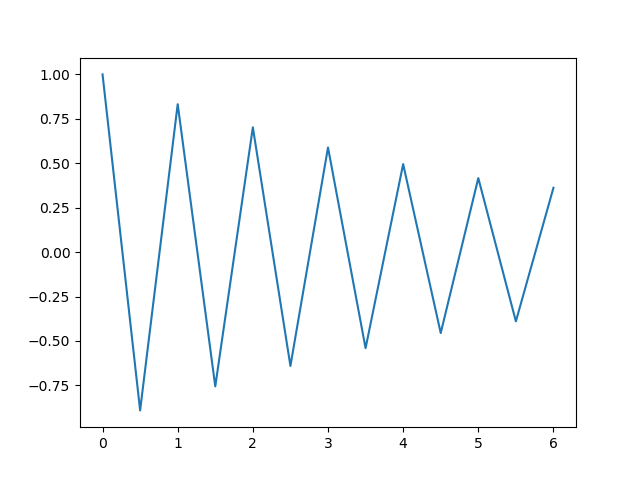

In [123]:
plt.plot(tlist,MExp/MExp[0])
plt.show()

In [9]:
dictpp=io.loadmat('M_z')
MxExp1=dictpp['M_z']
MxExp1=np.squeeze(MxExp1)
MxExp1.shape

(301,)

In [109]:
for p in np.array([1,2,1.2]):
    print(p)

1.0
2.0
1.2


In [104]:
band[0]

array([ 0.41236814,  0.38302404,  0.21864426,  0.20016707,  0.19777439,
        0.19451877,  0.19039057,  0.18210842,  0.17934232,  0.16636322,
        0.16228521,  0.15138061,  0.14917268,  0.1410223 ,  0.13594834,
        0.12839962,  0.12592809,  0.11556592,  0.11470878,  0.11292953,
        0.10030647,  0.09876307,  0.09281018,  0.08664374,  0.08576328,
        0.08530768,  0.08486557,  0.0775136 ,  0.07503835,  0.07220578,
        0.06944519,  0.0682481 ,  0.06720691,  0.06696543,  0.06423648,
        0.06377336,  0.06252998,  0.06151354,  0.05911683,  0.05839557,
        0.0576111 ,  0.05516185,  0.05417428,  0.05386198,  0.05382685,
        0.05058423,  0.05048744,  0.04992994,  0.04893468,  0.04715249,
        0.04683014,  0.04566644,  0.04510022,  0.04451689,  0.0438733 ,
        0.04320397,  0.04296757,  0.0426628 ,  0.04032193,  0.03888403,
        0.03864613,  0.0380734 ,  0.0376338 ,  0.03653412,  0.0359084 ,
        0.03540813,  0.03494545,  0.03427284,  0.03350344,  0.03